In [1]:
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from cv_bridge import CvBridge
import ipyvolume as ipv

#from zed_interfaces.msg import ObjectsStamped


In [2]:
# Create a typestore and get the string class.
typestore = get_typestore(Stores.ROS2_FOXY)


In [3]:
from pathlib import Path
from rosbags.typesys import Stores, get_types_from_msg, get_typestore

def guess_msgtype(path: Path) -> str:
    """Guess message type name from path."""
    name = path.relative_to(path.parents[2]).with_suffix('')
    if 'msg' not in name.parts:
        name = name.parent / 'msg' / name.name
    return str(name)

typestore = get_typestore(Stores.ROS2_FOXY)  # or Stores.ROS2_FOXY if you're using Foxy

# Paths to the .msg files for ObjectsStamped and its dependent types like Object
msg_paths = [
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/ObjectsStamped.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Object.msg',  # Add the path for the Object.msg file
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/BoundingBox2Di.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/BoundingBox2Df.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/BoundingBox3D.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Keypoint2Di.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Keypoint2Df.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Keypoint3D.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Skeleton2D.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Skeleton3D.msg',
]

add_types = {}

for pathstr in msg_paths:
    msgpath = Path(pathstr)
    msgdef = msgpath.read_text(encoding='utf-8')
    add_types.update(get_types_from_msg(msgdef, guess_msgtype(msgpath)))

# Register the custom types with the typestore
typestore.register(add_types)


In [4]:
fileroot='2024_03_08_TRF_Maleen/'
filename='2024_03_08_TRF_Maleen_01'

saverpath='/home/maleen/rosbags/Transformers/datasets/training/'

bagpath  = '/home/maleen/rosbags/Transformers/'+fileroot+ filename

# Initialize lists to store data
skeleton_timestamps = []
image_timestamps = []
skeleton_2d_data = []
skeleton_3d_data = []
image_data =np.array([])

with Reader(bagpath) as reader:
    for connection, timestamp, rawdata in reader.messages():
        # Handle skeletal data
        if connection.topic == '/zed/zed_node/body_trk/skeletons':
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            for obj in msg.objects:
                if obj.skeleton_available:
                    skeleton_2d_points = [kp.kp.tolist() for kp in obj.skeleton_2d.keypoints]
                    skeleton_3d_points = [kp.kp.tolist() for kp in obj.skeleton_3d.keypoints]

                    skeleton_timestamps.append(timestamp)
                    skeleton_2d_data.append(skeleton_2d_points[:18])
                    skeleton_3d_data.append(skeleton_3d_points[:18])
                
        # Handle image data
        elif connection.topic == '/zed/zed_node/rgb_raw/image_raw_color':
            image_timestamps.append(timestamp)
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            image_data = np.append(image_data,msg)

# Create a DataFrame
df = pd.DataFrame({
    'Skeleton_Timestamp': skeleton_timestamps,
    'Skeleton_2D': skeleton_2d_data,
    'Skeleton_3D': skeleton_3d_data,
})

print(df.head())


    Skeleton_Timestamp                                        Skeleton_2D  \
0  1709874089634082714  [[5144.537109375, 231.87551879882812], [4640.8...   
1  1709874089634082714  [[1084.9998779296875, 198.00001525878906], [10...   
2  1709874089694263104  [[5144.7099609375, 230.64134216308594], [4640....   
3  1709874089694263104  [[1082.382568359375, 198.04823303222656], [105...   
4  1709874089761206217  [[1082.4998779296875, 197.99998474121094], [10...   

                                         Skeleton_3D  
0  [[0.6100762486457825, -5.165032863616943, 0.14...  
1  [[0.7281906008720398, -0.5904041528701782, 0.2...  
2  [[0.6100485324859619, -5.164997100830078, 0.14...  
3  [[0.7653678059577942, -0.6167691946029663, 0.2...  
4  [[0.7895495295524597, -0.6364307403564453, 0.2...  


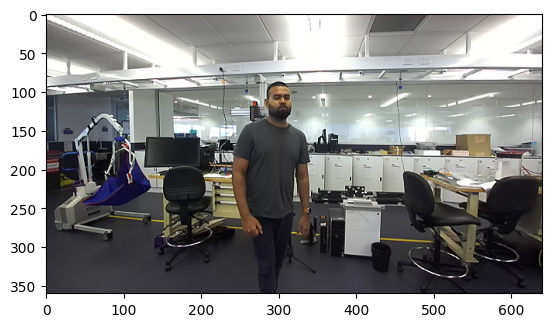

In [5]:
bridge = CvBridge()
detected_images=[]

for img in image_data:
    
    cv_image = bridge.imgmsg_to_cv2(img, desired_encoding="passthrough")
    detected_images.append(cv_image)

#TEST DETECTED IMAGES



plt.imshow(cv2.cvtColor(detected_images[500], cv2.COLOR_BGR2RGB))
#plt.imshow(detected_images[25])
plt.show()

In [6]:

# Original resolution
old_width, old_height = 1280, 720

# New resolution
new_width, new_height = 640, 360

# Calculate scaling factors
scale_x = new_width / old_width
scale_y = new_height / old_height

# Initialize a list to store scaled skeletal data
scaled_skeletal_data = []

# Iterate over each frame/observation
for frame in skeleton_2d_data:
    # Scale each point in the frame
    scaled_frame = [[x * scale_x, y * scale_y] if x > 0 and y > 0 else [x, y] for x, y in frame]
    scaled_skeletal_data.append(scaled_frame)

# Convert the list back to a NumPy array if needed
scaled_skeletal_data = np.array(scaled_skeletal_data, dtype=np.float32)

# Now, scaled_skeletal_data contains the scaled skeletal points for each frame/observation


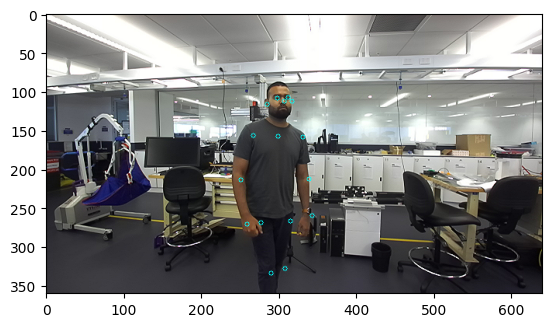

In [7]:
test_img=detected_images[500]

for point in scaled_skeletal_data[500]:
    x, y = int(point[0]), int(point[1])
    #print(x)
    cv2.circle(test_img, (x, y), radius=3, color=(255, 255, 0), thickness=1)  # Draw a green circle at each point
    
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
#plt.imshow(detected_images[25])
plt.show()

In [8]:
# Assuming `skeleton_3d_data[500]` is your input data
data = np.array(skeleton_3d_data[500])

# Filter out the NaN values from the first 18 keypoints
valid_keypoints = ~np.isnan(data[:18, :].any(axis=1))
filtered_data = data[:18][valid_keypoints]


# Define connections based on your body model (this is a basic example)
original_connections = [
    (16, 14),(14, 0),
    (17, 15),(15, 0),
    (0, 1),
    (1, 2), (2, 3), (3, 4),          # Right arm
    (1, 5), (5, 6), (6, 7),          # Left arm
    (1, 8), (8, 9), (9, 10),        # Right leg
    (1, 11), (11, 12), (12, 13),    # Left leg
    (8, 11)                          # Between hips
]

# Create a mapping from old indices to new indices after NaN removal
index_mapping = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints)[0])}

# Create a new list of connections that only includes the valid keypoints
new_connections = [(index_mapping[start], index_mapping[end])
                   for start, end in original_connections
                   if start in index_mapping and end in index_mapping]

# Create the 3D scatter plot
ipv.figure()
scatter = ipv.scatter(filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2], marker='sphere', size=2)

# Draw lines for the new skeletal links
for start, end in new_connections:
    ipv.plot(filtered_data[[start, end], 0], filtered_data[[start, end], 1], filtered_data[[start, end], 2], color='red')

# Show the plot
ipv.view(azimuth=0, elevation=-90)
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [9]:
df.to_pickle(saverpath + filename + '.pkl')

In [10]:
skeleton_3d_data[500]

[[1.2353566884994507, 0.09482375532388687, 0.29923978447914124],
 [1.2306528091430664, 0.13089004158973694, 0.08976670354604721],
 [1.2387707233428955, 0.27934131026268005, 0.09723604470491409],
 [1.2634809017181396, 0.3608987629413605, -0.17393270134925842],
 [1.1788359880447388, 0.30214306712150574, -0.4156939387321472],
 [1.3247528076171875, -0.017489692196249962, 0.08923213928937912],
 [1.4347885847091675, -0.06252721697092056, -0.19182570278644562],
 [1.3785518407821655, -0.08136140555143356, -0.4273681044578552],
 [1.240390419960022, 0.23491881787776947, -0.4268232583999634],
 [1.3359943628311157, 0.1869855374097824, -0.7879615426063538],
 [nan, nan, nan],
 [1.2523926496505737, 0.05712566897273064, -0.42420494556427],
 [1.4506542682647705, 0.10397161543369293, -0.8256626129150391],
 [nan, nan, nan],
 [1.246436595916748, 0.13646580278873444, 0.3224877417087555],
 [1.2601779699325562, 0.07291577756404877, 0.32767191529273987],
 [1.318057656288147, 0.20748718082904816, 0.30167016386